___

<a href='http://www.pieriandata.com'><img src='../Pierian_Data_Logo.png'/></a>
___
<center><em>Copyright Pierian Data</em></center>
<center><em>For more information, visit us at <a href='http://www.pieriandata.com'>www.pieriandata.com</a></em></center>
# RNN Example for Time Series

**TASK: IMPORT THE BASIC LIBRARIES YOU THINK YOU WILL USE**

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


## Data

Info about this data set: https://fred.stlouisfed.org/series/TRFVOLUSM227NFWA

Read in the data set "Miles_Traveled.csv" from the Data folder. Figure out how to set the date to a datetime index columns

In [3]:
df = pd.read_csv("..\Data\Miles_Traveled.csv", index_col='DATE', parse_dates=True)

In [4]:
df.index.freq = 'MS' #set frequency to monthly

In [5]:
df.head()

,TRFVOLUSM227NFWA
DATE,
1970-01-01,80173.0
1970-02-01,77442.0
1970-03-01,90223.0
1970-04-01,89956.0
1970-05-01,97972.0


**Task: Change the column names to Value**

In [6]:
df = df.rename(columns={'TRFVOLUSM227NFWA': 'Value'})

In [7]:
df.head()

,Value
DATE,
1970-01-01,80173.0
1970-02-01,77442.0
1970-03-01,90223.0
1970-04-01,89956.0
1970-05-01,97972.0


**TASK: Plot out the time series**

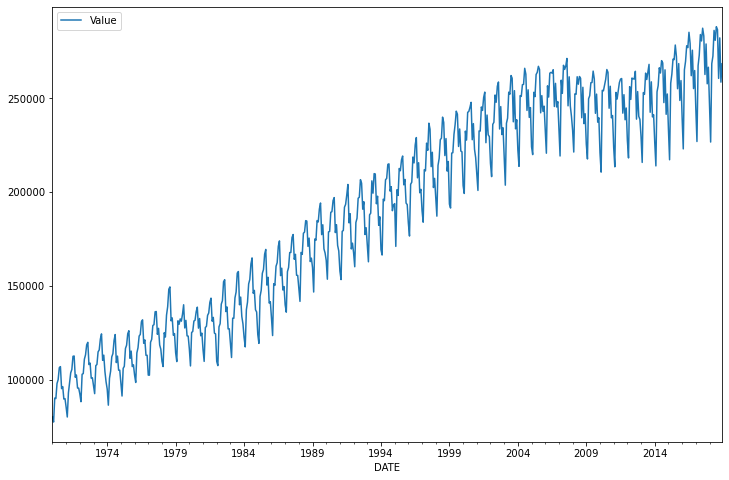

In [8]:
df.plot(figsize=(12, 8));

**TASK: Perform a Seasonal Decomposition on the model and plot out the ETS components**

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

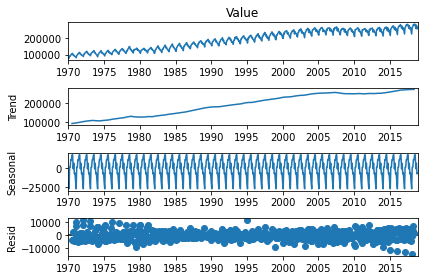

In [10]:
results = seasonal_decompose(df['Value'])

results.plot();

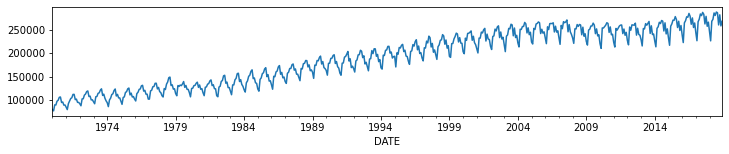

In [11]:
results.observed.plot(figsize=(12, 2));

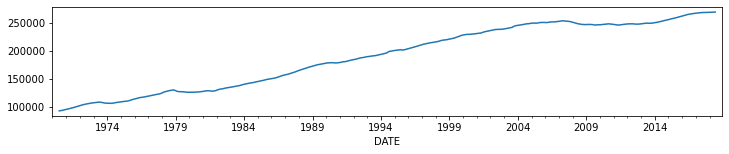

In [12]:
results.trend.plot(figsize=(12, 2));

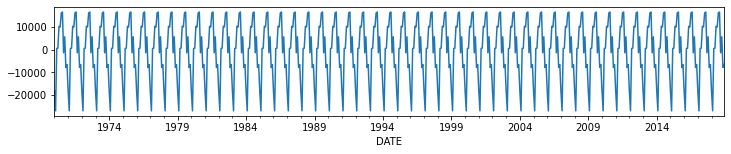

In [13]:
results.seasonal.plot(figsize=(12, 2));

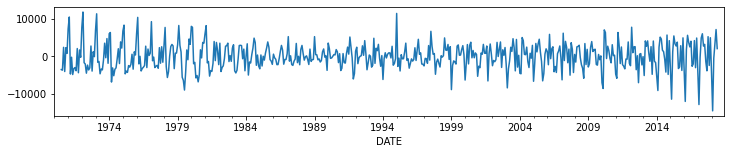

In [14]:
results.resid.plot(figsize=(12, 2));

## Train Test Split

**TASK: Figure out the length of the data set**

In [15]:
len(df)

588

**TASK: Split the data into a train/test split where the test set is the last 12 months of data.**

In [16]:
train = df.iloc[:(len(df) - 12)]
test = df.iloc[(len(df) - 12):]

print(len(test))

12


In [17]:
len(test)

12

## Scale Data

**TASK: Use a MinMaxScaler to scale the train and test sets into scaled versions.**

In [18]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
scaler = MinMaxScaler()

scaler.fit(train)

MinMaxScaler()

In [20]:
train_scaled = scaler.transform(train)
scaled_test = scaler.transform(test)

In [21]:
scaled_test

array([[0.80158265],
       [0.71089704],
       [0.91013382],
       [0.92916661],
       [0.99438307],
       [0.969195  ],
       [1.00382085],
       [0.99649835],
       [0.8725685 ],
       [0.9753741 ],
       [0.86301637],
       [0.90981463]])

# Time Series Generator

**TASK: Create a TimeSeriesGenerator object based off the scaled_train data. The n_input is up to you, but at a minimum it should be at least 12.**

In [22]:
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [23]:
train_generator = TimeseriesGenerator(train_scaled, train_scaled, length=12, batch_size=1)

### Create the Model

**TASK: Create a Keras Sequential Model with as many LSTAM units you want and a final Dense Layer.**

In [24]:
train.tail(24)

,Value
DATE,
2016-01-01,239679.0
2016-02-01,223011.0
2016-03-01,265147.0
2016-04-01,269653.0
2016-05-01,277972.0
2016-06-01,276991.0
2016-07-01,285160.0
2016-08-01,279213.0
2016-09-01,262039.0


In [25]:
model = Sequential()

model.add(LSTM(150, activation='relu', input_shape=(12, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

**TASK: Fit the model to the generator (it should be a lot of epochs, but do as many as you have the patience for! :)**

In [26]:
model.fit_generator(train_generator, epochs=10)

Epoch 1/10
564/564 [==============================] - 11s 19ms/step - loss: 0.0122

**TASK: Plot the history of the loss that occured during training.**

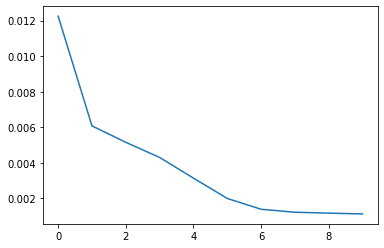

In [27]:
# model.history.history.keys()

plt.plot(range(len(model.history.history['loss'])), model.history.history['loss']);

## Evaluate on Test Data

**TASK: Based on your test data and input size, create an appropriate;y sized "first evaluation batch" like we did in the lecture.**

In [28]:
first_eval_batch = train_scaled[-12:]
first_eval_batch = first_eval_batch.reshape((1, 12, 1))

In [29]:
first_eval_batch

array([[[0.79630397],
        [0.71226435],
        [0.90477416],
        [0.93121043],
        [0.98386382],
        [0.96757519],
        [1.        ],
        [0.9801859 ],
        [0.8824684 ],
        [0.95995255],
        [0.85883345],
        [0.90086755]]])

**TASK: Generate predictions into the same time stamps as the test set**

In [30]:
test_predictions = []

first_eval_batch = train_scaled[-12:]

current_batch = first_eval_batch.reshape((1, 12, 1))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]

    test_predictions.append(current_pred)

    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

## Inverse Transformations and Compare

**TASK: Inverse Transform your new forecasted predictions.**

In [34]:
true_predictions = scaler.inverse_transform(test_predictions)

true_predictions

array([[248261.96878392],
       [240196.75462407],
       [265224.2959832 ],
       [272718.04179114],
       [278157.13136011],
       [278719.39156115],
       [280806.38892782],
       [277739.3490479 ],
       [269536.98848891],
       [273515.86050367],
       [263623.60408401],
       [265004.31375951]])

**TASK: Create a new dataframe that has both the original test values and your predictions for them.**

In [35]:
test['Predictions'] = true_predictions

C:\Users\User\.virtualenvs\Unit4-Sprint2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
test

,Value,Predictions
DATE,,
2018-01-01,245695.0,248261.968784
2018-02-01,226660.0,240196.754624
2018-03-01,268480.0,265224.295983
2018-04-01,272475.0,272718.041791
2018-05-01,286164.0,278157.131360
2018-06-01,280877.0,278719.391561
2018-07-01,288145.0,280806.388928
2018-08-01,286608.0,277739.349048
2018-09-01,260595.0,269536.988489


**TASK: Plot out the test set against your own predicted values.**

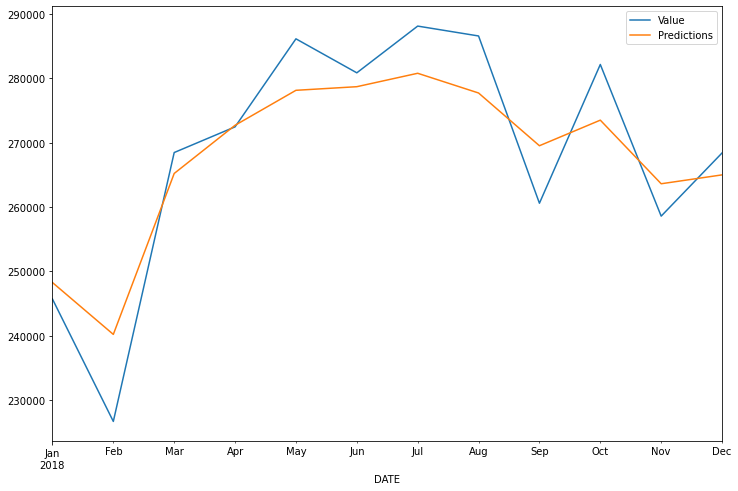

In [37]:
test.plot(figsize=(12, 8));

# Saving Models

**TASK: Optional, Save your model!**

In [38]:
model.save('rnn_exercise.h5')